In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from pprint import pprint
from itertools import combinations
from math import ceil
from scipy.stats import linregress
from collections import defaultdict
from Bio import SeqIO

In [27]:
## Read in data; use the ID to index individual observations
counts = pd.read_excel('../data/counts/2017.07.05.annotatedCounts.xlsx', index_col=0)
outfile = '../data/counts/2017-07-05_enrichment.csv'
def standardize(df):
    ''' Standardize each column of the data frame such that mean = 0 and stddev = 1 '''
    df = df.sub(df.mean(0), axis='columns').div(df.std(0), axis='columns')
    return df


def normalize(df):
    ''' Normalize each column of the data frame so it ranges from 0 to 1'''
    xmin = df.min(0)
    xmax=df.max(0)
    xmax_minus_xmin = xmax - xmin
    df = df.sub(xmin, axis='columns').div(xmax_minus_xmin, axis='columns').multiply(100.)
    return df

def proportions(df):
    xsum=df.sum(0)
    df = df.div(xsum, axis='columns')
    return df


### For convenience, separate out the metadata, input counts, background counts, and observed counts.
### Normalize each column while we're at it TODO

input_counts = normalize(counts[['Input_1', 'Input_2', 'Input_3']])
background_counts = normalize(counts[[u'Beads-only_1', u'Beads-only_2', u'Beads-only_3',u'Beads-only_4' ,u'Beads-only_5', u'Beads-only_6']])
metadata = counts[['Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence']]
output_counts = normalize(counts[[ u'240-D_1',u'240-D_2', u'240-D_3', u'447-52D_1', u'447-52D_2', u'447-52D_3', u'4G2_1',
u'4G2_2', u'4G2_3' ,u'DV63_1', u'DV63_2',u'DV63_3', u'Flu_1', u'Flu_2', u'Flu_3', u'NS1_1', u'NS1_2' ,u'NS1_3', 
u'PGT145_1', u'PGT145_2', u'PGT145_3',u'QA013_1', u'QA013_2', u'QA013_3', u'VRC01_1' ,u'VRC01_2', u'VRC01_3',
u'ZV-48_1' ,u'ZV-48_2', u'ZV-48_3']])

In [28]:
sns.set(style='whitegrid', font_scale = 1.3, palette='pastel') ## Make all of our plots prettier

def compare_replicates(df, columns, title):
    ''' Plot sanity checks for technical replicates '''
    replicates = df[columns]    
    replicates.fillna(0, inplace=True)
    
    def plot_comparison(x,y, **kwargs):
        r_2 = linregress(x,y)[2]
        scatter = plt.plot(x,y, 'o', alpha=0.4)
        scatter[0].axes.text(0,0, 'R^2 = %.2f'%(r_2))
        return scatter
        
    g = sns.PairGrid(replicates, diag_sharey=False)
    g.map_diag(sns.violinplot)
    g.map_offdiag(plot_comparison, )
    
    g.fig.suptitle(title, va='bottom')
    plt.tight_layout()
    plt.show()

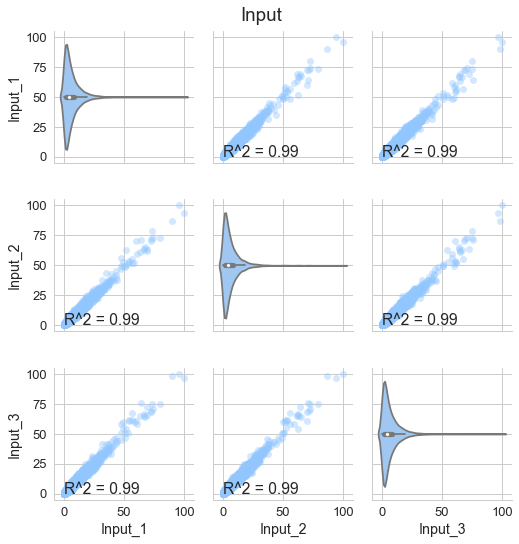

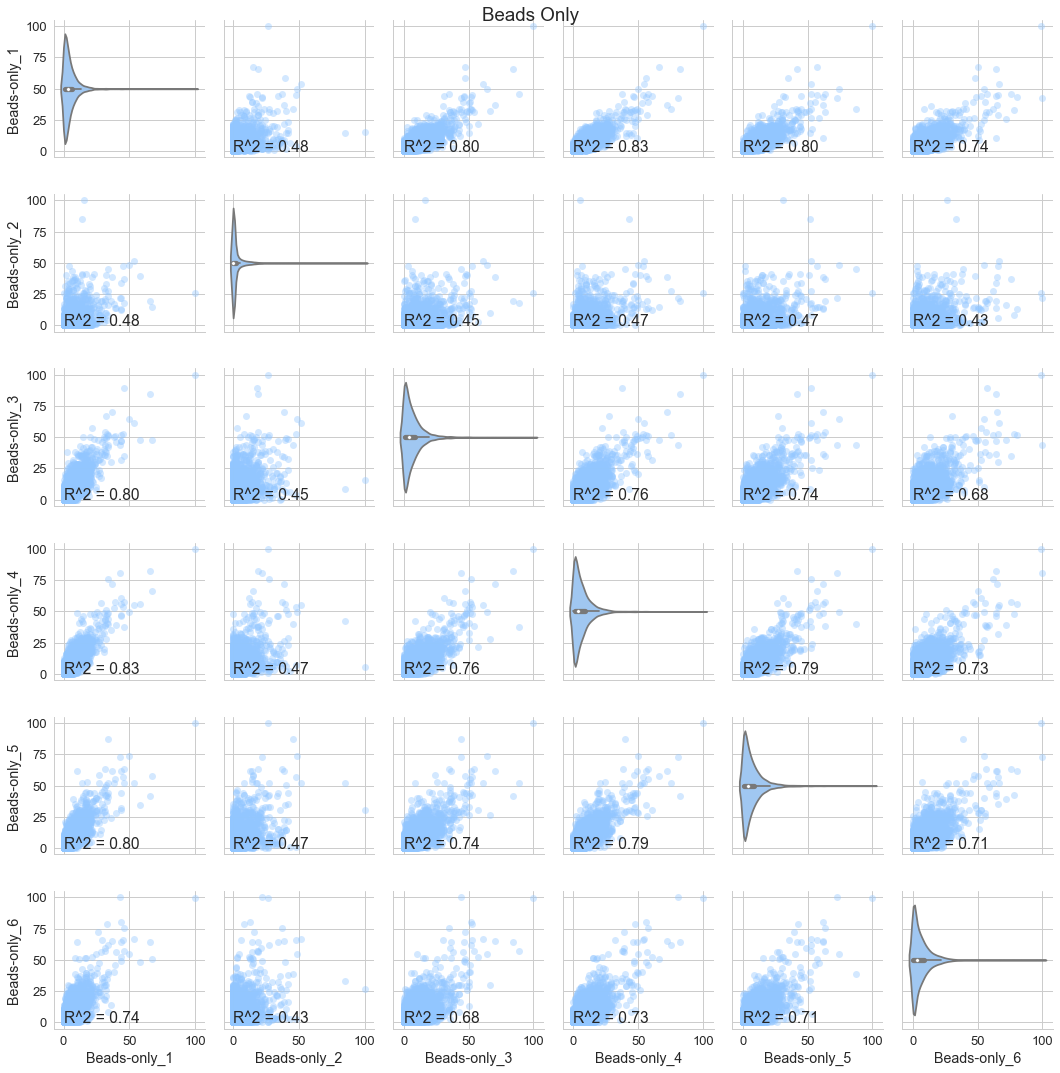

In [29]:
## Sanity check the controls

compare_replicates(input_counts, input_counts.columns.values, 'Input')
compare_replicates(background_counts, background_counts.columns.values, 'Beads Only')

In [30]:
### Find the mean of the input and background vals
input_counts['average'] = input_counts.mean(axis=1)

background_counts.drop(['Beads-only_2'], axis=1, inplace=True) # This replicate is weird and disagrees with the other 5 replicates; drop it
background_counts['average'] = background_counts.mean(axis=1)

In [31]:
def calc_enrichment(column, input_vals = input_counts['average'], background_vals = background_counts['average']):
    ''' Naive first pass: output/input - background/input '''
    background_enrichment = background_vals.div(input_vals)
    column_enrichment = column.div(input_vals)
    enrichment = column_enrichment.sub(background_enrichment)
    enrichment[enrichment<0] = 0. # Take min(score, 0)
    return enrichment

enrichment = output_counts.apply(calc_enrichment, axis=0)

### This has some issues, mainly that the background is only normalized to itself, so it's highly overrepresented. TODO

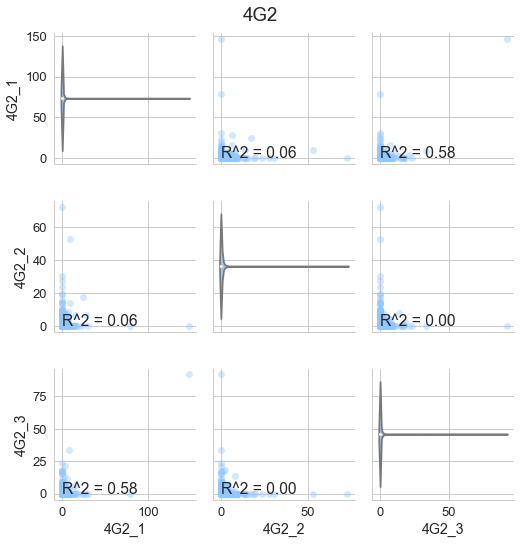

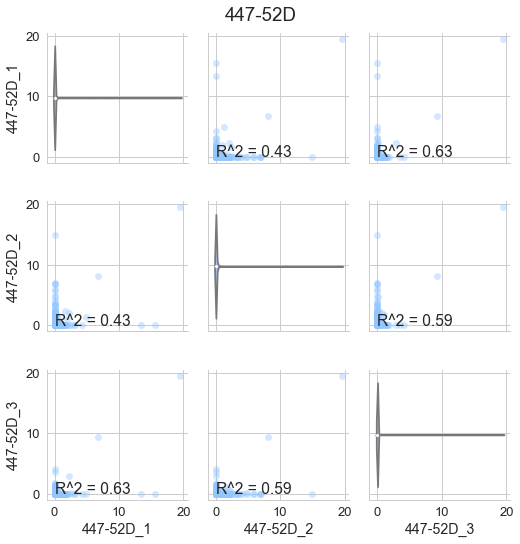

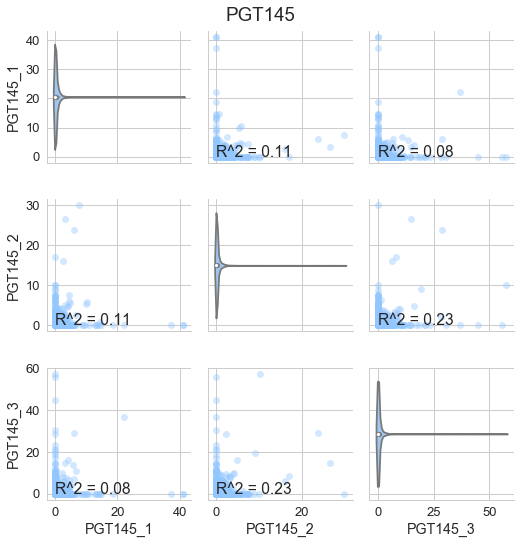

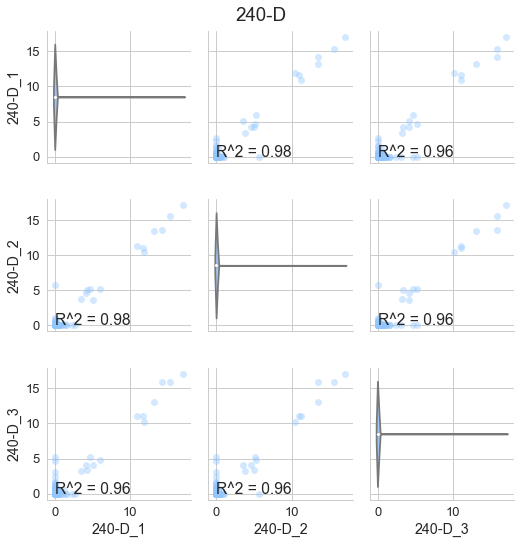

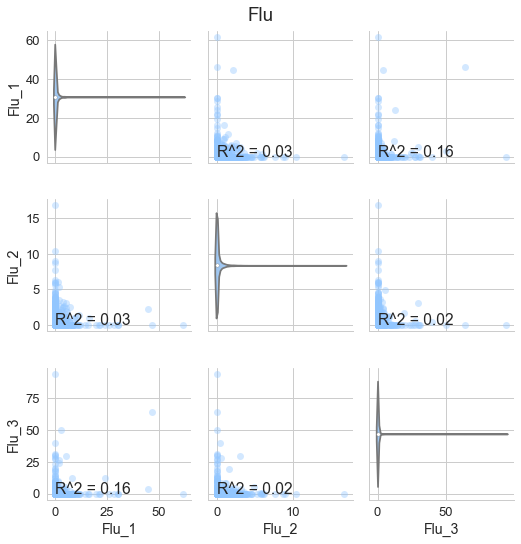

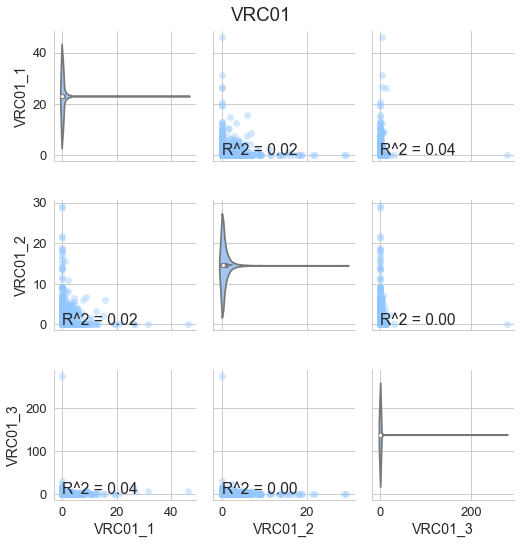

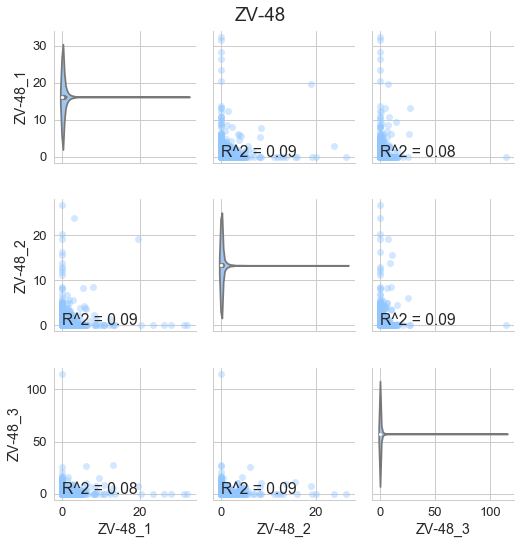

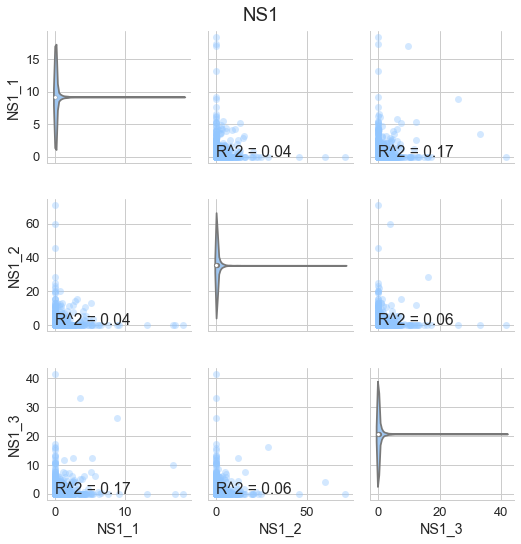

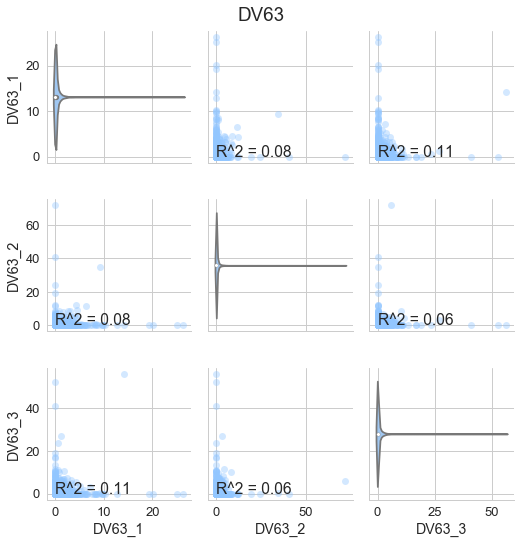

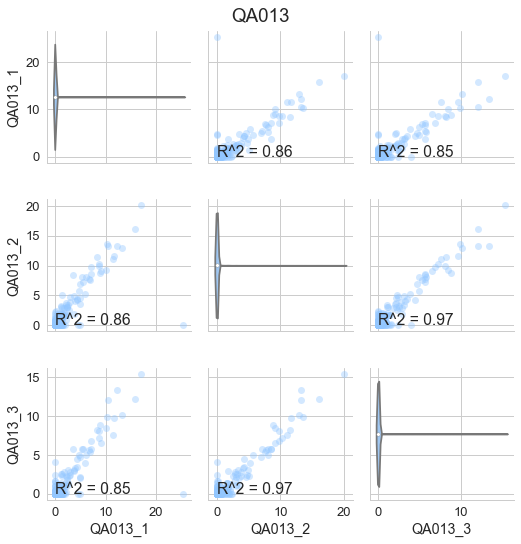

In [32]:
### Look at technical replicates for each sample; these will look MUCH better once we fix the overrepresentation of background.
replicates = defaultdict(list)
for serum in enrichment.columns.values:
    replicates[serum.split('_')[0]].append(serum)
replicates = dict(replicates)

for sera, reps in replicates.items():

    compare_replicates(enrichment, reps, sera)

In [33]:
## Add the names of any particular replicates that seem "off" relative to the others
funky_replicates = [] 
if funky_replicates != []:
    enrichment.drop(funky_replicates, inplace=True, axis=1)

## Aggregate technical replicates

aggregated_enrichment = pd.DataFrame(index=enrichment.index.values)

for sera, reps in replicates.items():
    aggregated_enrichment[sera] = enrichment[reps].mean(axis=1)
    
print aggregated_enrichment.head()

                     4G2   447-52D    PGT145  240-D       Flu     VRC01  \
1               0.000000  0.000000  0.082360    0.0  0.283665  0.042808   
100             0.217751  0.000000  0.020719    0.0  0.000000  0.301280   
1001            0.000000  0.000000  0.000000    0.0  0.000000  0.225073   
1002            0.129093  0.170635  0.569677    0.0  0.000000  1.573085   
1008.1177.1346  0.053406  0.000000  0.050696    0.0  0.007039  0.190642   

                   ZV-48       NS1      DV63  QA013  
1               0.008574  0.076451  0.058737    0.0  
100             0.088376  0.000000  0.193040    0.0  
1001            0.103023  0.000000  0.165936    0.0  
1002            0.772511  0.479384  0.363651    0.0  
1008.1177.1346  0.161057  0.000000  0.000000    0.0  


In [34]:
### Tidy up the metadata a bit

## Tidy start and end coordinates --> integers
metadata['start'], metadata['end'] = metadata['Start_to_End_nt'].str.split('to', 1).str
metadata['start'] = metadata['start'].map(lambda x: int(x))
metadata['end'] = metadata['end'].map(lambda x: int(x.split('.')[0])) ## TODO
metadata.drop('Start_to_End_nt', inplace=True, axis=1)

def parse_strains(virusstrain):
    
    if 'HIV' in virusstrain:
        # e.g., 'HIV_Env_QB850.72p.C14_A1.HIV_Env_QB850.632p.B10'
        gene = virusstrain.split('HIV_', 1)[1].split('_', 1)[0] # Env
        virus = 'HIV'+'_'+gene.upper() #HIV_ENV
        strains = virusstrain.split('HIV_%s_'%gene) # ['QB850.72p.C14_A1.', 'QB850.632p.B10']
        strains = [ s.replace('.', '').replace('_', '').replace('-', '').upper() for s in strains if s != '']
        # ['QB85072PC14A1', 'QB850632PB10']
        
    else:
        try:
            # e.g., 'DENV3_BR-BID-V2403-2008.DENV3_Mozambique1985'
            # The ONNV sequences overlap with the CHIKV sequences; for now, we'll omit it; this should be revisited. TODO
            names = [s for s in virusstrain.split('.') if 'ONNV' not in s] # ['DENV3_BR-BID-V2403-2008', 'DENV3_Mozambique1985']
            virus = [s.split('_', 1)[0] for s in names] # ['DENV3']
            assert len(set(virus)) == 1#, ('ERROR: Multiple viruses at this locus', virus)
            virus = virus[0] # 'DENV3'
            strains = [s.split(virus+'_', 1)[1].replace('-', '').replace('_', '').upper() for s in names if s != '']
            # ['BRBIDV24032008', 'MOZAMBIQUE1985']

        except Exception as e:
            return pd.Series({'virus': np.nan, 'strains':np.nan})
        
    return pd.Series({'virus': virus, 'strains':strains})

new_names = pd.DataFrame([parse_strains(v) for v in metadata['Virus_Strain']], columns=['virus', 'strains'])
metadata = metadata.join(new_names)

metadata.drop('Virus_Strain', axis=1, inplace=True)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/P

In [35]:
metadata.dropna(how='any', inplace=True, axis=(0, 1))
print metadata.head()

                             Peptide_sequence  start   end    virus  \
id                                                                    
1     MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHAN      1   118    CHIKV   
100   PESAVAACNEFLARNYPTVSSYQITDEYDAYLDMVDGSE   5941  6058    CHIKV   
1001  AVSMANIFRGSYLAGAGLLFSIMKNTTNTRRGTGNVGET   7381  7498  HIV_ENV   
1002  SIMKNTTNTRRGTGNVGETLGEKWKSRLNALGKSEFQIY   7441  7558  HIV_ENV   
101   SYQITDEYDAYLDMVDGSESCLDRATFNPSKLRSYPKQH   6001  6118    DENV2   

                strains  
id                       
1             [KPA15NS]  
100           [KPA15NS]  
1001          [CLADEA2]  
1002          [CLADEA2]  
101   [BURKINAFASO1983]  


In [36]:
final_enrichment = aggregated_enrichment.join(metadata, how='inner') # annotated, aggregated enrichment scores
print final_enrichment.head()
final_enrichment.to_csv(outfile)

           4G2   447-52D    PGT145  240-D       Flu     VRC01     ZV-48  \
1     0.000000  0.000000  0.082360    0.0  0.283665  0.042808  0.008574   
100   0.217751  0.000000  0.020719    0.0  0.000000  0.301280  0.088376   
1001  0.000000  0.000000  0.000000    0.0  0.000000  0.225073  0.103023   
1002  0.129093  0.170635  0.569677    0.0  0.000000  1.573085  0.772511   
101   0.389363  0.000000  0.360859    0.0  0.508884  0.621858  0.709760   

           NS1      DV63  QA013                         Peptide_sequence  \
1     0.076451  0.058737    0.0  MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHAN   
100   0.000000  0.193040    0.0  PESAVAACNEFLARNYPTVSSYQITDEYDAYLDMVDGSE   
1001  0.000000  0.165936    0.0  AVSMANIFRGSYLAGAGLLFSIMKNTTNTRRGTGNVGET   
1002  0.479384  0.363651    0.0  SIMKNTTNTRRGTGNVGETLGEKWKSRLNALGKSEFQIY   
101   0.000000  0.485040    0.0  SYQITDEYDAYLDMVDGSESCLDRATFNPSKLRSYPKQH   

      start   end    virus            strains  
1         1   118    CHIKV          [KPA15NS

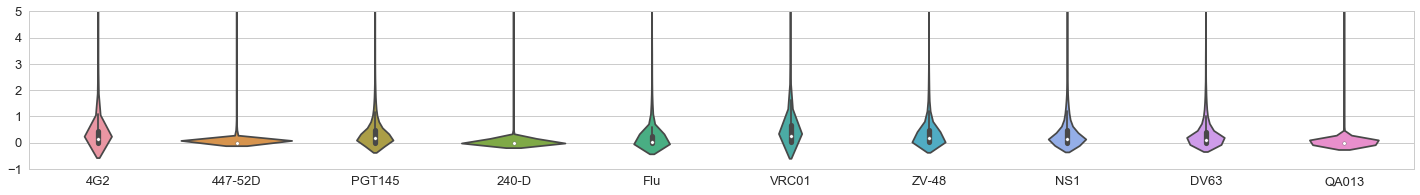

In [23]:
plt.subplots(figsize=(20,3))
sns.violinplot(data=aggregated_enrichment, order=aggregated_enrichment.columns.values)
plt.ylim(-1, 5)
plt.tight_layout()